In [1]:
from google.colab import drive
drive.mount('/content/drive')

BASE = '/content/drive/MyDrive/traffic_sign_classifier_ml_algorithms/'
DS_SPLIT = BASE + 'dataset_split/'

Mounted at /content/drive


In [2]:
pip install torch torchvision matplotlib notebook numpy scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 71.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 53.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 93.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 74.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
import pandas as pd
import torch
import torchvision
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

In [4]:
IMG_SIZE = (64, 64)
def load_images_from_folder(folder):
    images, labels = [], []
    class_names = sorted(os.listdir(folder))
    for class_index, class_name in enumerate(class_names):
        class_folder = os.path.join(folder, class_name)
        if not os.path.isdir(class_folder): continue
        for filename in os.listdir(class_folder):
            file_path = os.path.join(class_folder, filename)
            try:
                img = Image.open(file_path).convert('RGB').resize(IMG_SIZE)
                images.append(np.array(img).flatten())
                labels.append(class_index)
            except Exception as e:
                print(f"Erro ao carregar {file_path}: {e}")
    return np.array(images), np.array(labels), class_names

In [ ]:
X_train, y_train, class_names = load_images_from_folder(DS_SPLIT + 'train')
X_val, y_val, _ = load_images_from_folder(DS_SPLIT + 'val')
X_test, y_test, _ = load_images_from_folder(DS_SPLIT + 'test')

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
train_data = datasets.ImageFolder(DS_SPLIT + 'train', transform)
val_data = datasets.ImageFolder(DS_SPLIT + 'val', transform)
test_data = datasets.ImageFolder(DS_SPLIT + 'test', transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

print('Classes:', train_data.classes)

Classes: ['bump', 'no parking', 'pedestrian crossing', 'speed limit', 'stop']


In [ ]:
model = models.mobilenet_v2(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
model.classifier[1] = nn.Linear(model.last_channel, 5)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 83.3MB/s]


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier[1].parameters(), lr=0.001)

In [ ]:
num_epochs = 5
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

Epoch [1/5], Train Loss: 1.5969, Val Loss: 1.3861
Epoch [2/5], Train Loss: 1.2691, Val Loss: 1.2332
Epoch [3/5], Train Loss: 1.0518, Val Loss: 1.0908
Epoch [4/5], Train Loss: 0.8901, Val Loss: 0.9685
Epoch [5/5], Train Loss: 0.7309, Val Loss: 0.8612


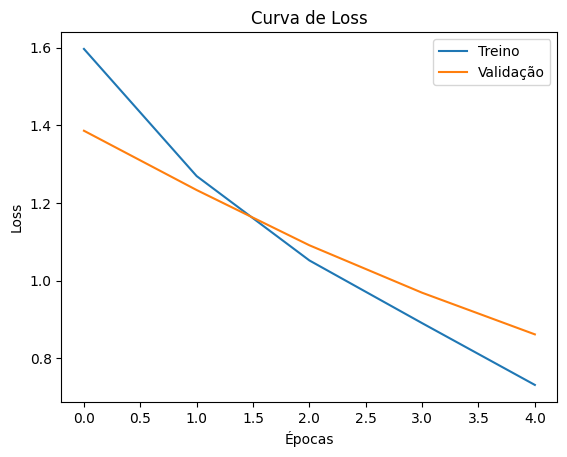

In [ ]:
plt.plot(train_losses, label='Treino')
plt.plot(val_losses, label='Validação')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.title('Curva de Loss')
plt.show()

In [ ]:
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print('Accuracy:', accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred, target_names=train_data.classes))

Accuracy: 0.7903225806451613
                     precision    recall  f1-score   support

               bump       0.85      0.92      0.88        12
         no parking       0.82      0.75      0.78        12
pedestrian crossing       0.89      0.67      0.76        12
        speed limit       0.71      0.86      0.77        14
               stop       0.75      0.75      0.75        12

           accuracy                           0.79        62
          macro avg       0.80      0.79      0.79        62
       weighted avg       0.80      0.79      0.79        62



In [ ]:
MODEL_PATH = BASE + 'mobilenet_finetuned.pt'
torch.save(model.state_dict(), MODEL_PATH)